# IACS 2019 interpretability + fairness workshop

In [1]:
### Imports

# Native
import random
import warnings
import itertools

# The usual suspects
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Deep learning
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions

# Sklearn and skimage
from sklearn.neighbors import BallTree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix, auc, f1_score, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from skimage.segmentation import mark_boundaries

# LIME 
from lime import lime_text
from lime import lime_image
from lime.lime_tabular import LimeTabularExplainer
from lime.lime_text import LimeTextExplainer

# Shapley values
import shap

# Custom
import interp

# AIF360 imports
from aif360.algorithms.preprocessing import OptimPreproc
from aif360.datasets import AdultDataset
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools

sns.set_palette('muted', color_codes=True)
%matplotlib inline

Using TensorFlow backend.


<br>
<br>
<br>

# Step 0: Download the data and perform EDA

For this notebook, we'll using the LendingClub dataset.  This data covers LendingClub's open peer-to-peer lending data from 2012 to 2018.  The dataset contains features about the borrower, and each row represents a loan.  We've done a bit of pre-cleaning for this version.

[Click here to download the dataset](https://drive.google.com/file/d/1yVUnuSA19CHyLbeyfCkunp5AGKzyBKLx/view?usp=sharing).  Be sure to save it in the data/ directory in the repo.

Then, run the cell below to see if you import it:

In [2]:
# Import cleaned data
df = pd.read_csv('../data/loans_data.csv')
print(f'Import successful!  We have {len(df)} rows.')
df.head()

Import successful!  We have 805148 rows.


,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,...,emp_length,home_ownership,verification_status,zip_code,term,initial_list_status,disbursement_method,application_type,loan_status,age_of_cr_line
0,5000.0,0.1065,24000.0,27.65,0.0,735.0,1.0,34.446551,70.816146,3.0,...,10+ years,RENT,Verified,860xx,36,f,Cash,Individual,1,34.0
1,2500.0,0.1527,30000.0,1.00,0.0,740.0,5.0,34.446551,70.816146,3.0,...,< 1 year,RENT,Source Verified,309xx,60,f,Cash,Individual,0,20.0
2,2400.0,0.1596,12252.0,8.72,0.0,735.0,2.0,34.446551,70.816146,2.0,...,10+ years,RENT,Not Verified,606xx,36,f,Cash,Individual,1,18.0
3,10000.0,0.1349,49200.0,20.00,0.0,690.0,1.0,35.000000,70.816146,10.0,...,10+ years,RENT,Source Verified,917xx,36,f,Cash,Individual,1,23.0
4,3000.0,0.1269,80000.0,17.94,0.0,695.0,0.0,38.000000,70.816146,15.0,...,1 year,RENT,Source Verified,972xx,60,f,Cash,Individual,1,23.0


## Exercise 0:

Find the distribution of `fico_range_low` for defaulted loans and paid back loans.  Are these distributions different? Do they match your expectations?
<br>
- HINT: The response column is `loan_status` with a 1 = paid back loan and 0 = defaulted loan 

In [ ]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 1: Build our model

### Seperate out into train and test

Our objective is to build a model that predicts if someone will default on a loan.  We've supplied a set of columns to use for the predictive model.  

In [4]:
# One hot encoding and subset into train/test 
quant_cols = ['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',\
              'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',\
              'revol_bal', 'revol_util', 'total_acc', 'acc_now_delinq', 'tot_coll_amt',\
              'tot_cur_bal', 'tax_liens', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit',\
              'age_of_cr_line', 'installment']

cat_cols = ['grade','emp_length', 'home_ownership','verification_status', 'term', 'initial_list_status',\
            'disbursement_method', 'application_type']

other_cols = ['zip_code']
response_col = 'loan_status'

df_x = pd.get_dummies(df[quant_cols+cat_cols], drop_first=False, columns=cat_cols)
df_y = df[response_col]

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

### Model plotting functions 
These are some functions we commonly use to plot model results. 

In [5]:
def plot_confusion_matrix(y_vals, y_preds, classes=['Negative', 'Positive'], normalize=False, \
                          title='Confusion matrix', cmap=plt.cm.Reds, ax=None):
    """ This function prints and plots the confusion matrix. Normalization can be applied 
    by setting `normalize=True`.
    -------
    Args:
        y_vals (iterable): The true y values of the classifier 
        y_preds (iterable): The predicted y values from the classifier
        classes (iter): iterable with the class names in it. Default: [Negative, Positive]
        normalize (bool): to normalize the confusion matrix or not. Default: False
        title (str): the title of the plot. Default: 'Confusion Matrix'
        cmap (matplotlib.cm): a colormap to color the confusion matrix with 
        ax (plt.Axes): axis to plot on 
    -------
    Returns:
        (plt.Axes)
    """
    cm = confusion_matrix(y_vals, y_preds)

    if ax is None:
        ax = plt.axes()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    PCM = ax.get_children()[9]
    plt.colorbar(PCM, ax=ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="grey" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()
    return ax

def plot_roc(tfpr, ttpr, fpr=None, tpr=None, grid=True, ax=None):
    """ Function to plot the roc curve for a model given the test and (maybe) training tpr and fpr
    ---------
    Args:
        tfpr (np.array): the test false positive rates 
        ttpr (np.array): the test true positive rates 
        fpr (np.array): the train false positive rates 
        tpr (np.array): the train true positive rates 
        grid (bool): plot grid?
        ax (plt.Axes): axis to plot on 
    ---------
    Returns:
        (plt.Axes)
    """ 
    train = tpr is not None and fpr is not None

    if ax is None:
        ax = plt.axes()

    lw = 2
    if train:
        ax.plot(fpr, tpr, color='#A25100',
             lw=lw, label='ROC curve - train', alpha=0.4)
    ax.plot(tfpr, ttpr, color='#A20000',
             lw=lw, label='ROC curve - test', alpha=0.4)
    ax.plot(np.linspace(0,1,10), np.linspace(0,1,10), '--', color='grey', alpha=0.4)
    ax.set_xlim([-0.025, 1.0])
    ax.set_ylim([0.0, 1.025])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc="lower right")
    if grid:
        ax.grid(color='grey', zorder=1, alpha=.15)
    sns.despine(offset=0, trim=False)
    return ax


### Fit model

Let's fit a model to the LendingClub data and see how well we do.  

We will use a Random Forest because it is a high-capacity model which cannot be explained trivially. 


Accuracy Train: 0.9977; Accuracy Test: 0.7959
AUC train: 1.0; AUC test: 0.6856


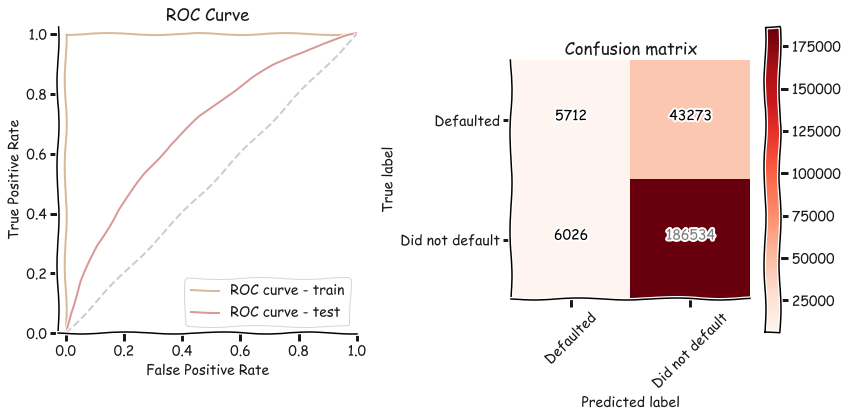

In [6]:
model = RandomForestClassifier(n_estimators=25, max_depth=None, \
                               random_state=42).fit(x_train, y_train)

# Calc AUC and ROC curve + CM
fpr, tpr, _ = roc_curve(y_train, model.predict_proba(x_train)[:, 1], pos_label=1)
auc_train = auc(fpr.reshape(-1, 1), tpr.reshape(-1, 1))
tfpr, ttpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:, 1], pos_label=1)
auc_test = auc(tfpr.reshape(-1, 1), ttpr.reshape(-1, 1))

print(f'Accuracy Train: {round(model.score(x_train, y_train),4)};',\
      f'Accuracy Test: {round(model.score(x_test, y_test),4)}')
print(f'AUC train: {round(auc_train,4)}; AUC test: {round(auc_test,4)}')

with plt.xkcd():   
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
    plot_roc(tfpr,ttpr,fpr,tpr, ax=ax1)
    plot_confusion_matrix(y_test, model.predict(x_test), classes=['Defaulted','Did not default'], ax=ax2)
    plt.tight_layout()
    plt.show()

### Exercise 1: Plot the feature importances for the random forest model. 
- HINT: sklearn ensemble models have an attribute `.feature_importances_` which may be useful

As always, feel free to google around to find examples! 

We can look at feature importances for the model because it's a tree-based ensemble.  Feature importances are good for a quick look but they can sometimes be [misleading](https://explained.ai/rf-importance/index.html).  

Even if the calculated feature importances are faithful to the model's structure, we still do not know the importance of certain features for *individual* observations or *sub-groups* of observations.

In [29]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### Exercise 2: Build model prediction for observation 95329.
- HINT: you can access an observation by number using `.values` on a pandas dataframe with numpy indexing `[row, col]`

In [8]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



Obs 95329 predicted to default on loan


<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 2: Local Perturbations

We are going to focus on [LIME (Local Interperetable Model-agnostic Explainations)](https://github.com/marcotcr/lime) for our local interperatability section.  

LIME works by making a linear approximation to the model's decision boundary at the specified point and using the coefficients of the linear approximation to explain the model's behavior at that point.  This means LIME is pretty fast, but it also means the results are not 100% stable.  

LIME builds its linear approximation by perturbing points around the chosen point and feeding them into a regression model to classify which side of the model's decision boundary they are on.  Once the linear approximation is made (accuracy is not a metric that is quantified in the LIME package thus far), the coefficients of the linear approximation are used to explain the model's behavior at that point.  

In [9]:
# Make the LIME explainer with training data
explainer = LimeTabularExplainer(x_train.values, feature_names=x_train.columns, training_labels=y_train,\
                                 class_names=['Defaulted', 'Did not default'], kernel_width=4, random_state=42)

### Exercise 3: Build LIME interpretation for observation 95329.
- HINT: you can look at [LIME examples](https://github.com/marcotcr/lime) and remember to `show_in_notebook` for nice visualization.

In [30]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### LIME prediction
- This is for a single observation 
- LIME approximates the decision boundary of the model with a line 

This example shows our model making a reasonable, but worrisome decision.  Although the prediction is Default, and based on our intuition about loans we would predict the same result, the way the model arrives at its conslusion is problematic.  Features like a high interest rate and a high debt-to-income ratio are both indicative of a *higher* chance of paying back the loan.  

This is counter intuiative because we would not normally expect someone who already has a lot of debt to pay back a loan with higher probability than someone with a low interest rate loan without much debt. This requires further investigation.

<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 3: Decision Boundaries

We're going to look at bivariate (2D) and univariate (1D) decision boundaries in this step.

### Bivariate decision boundary plot

This plot uses the ranges of two features and the closest existing point to each pair of feature values to make the 2D decision boundary. The plot gives us a good approximation to the model's decision boundary between the two features.

We can use this plot to check if the model's decision boundary looks as we would expect, and see where our point lies. 

In [11]:
# Helper functions
def plot_decision_boundary_2d(df_x, model, col1, col2, title, df_y=None, 
                              samples=True, save_path=None, ax=None):
    """ This function plots the approximate decision boundary in the 2D space 
    of the columns specified. It works by building a KD-Tree of the points made 
    by the values of the specified columns and then looking up the closest point 
    to the values we create on our interval for plotting. We use the feature values 
    of the closest point as the feature values of the columns not being plotted 
    when determining the decision boundary.  So to clarify this is an ESTIMATE. 
    We also plot the actual points and decisions so the user can see where the estimate fails.
    ------
    Args: df_x; pandas dataframe with the x data
          model; any valid model with a .predict_proba method 
          col1; string representing the first column (x axis of the plot)
          col2; string representing the second column (y axis of the plot)
          title; string that is the title of the plot 
          save_path; path to save the figure to. does not save if left on default which 
                is None. Note: you have to include what you want to save it as with the extension 
                e.g. save_path='../reports/decision_boundary.png'
          df_y; either numpy array or panads series with y values defaults to None 
                and real points are not included  
    ------
    Returns: None 
    """
    if ax is None:
        ax = plt.axes()
        
    # DataFrame top numpy transition 
    x = df_x.values
    c1 = list(df_x.columns).index(col1)
    c2 = list(df_x.columns).index(col2)
    
    # Make the kd tree
    kdtree = BallTree(x[:,[c1,c2]], leaf_size=400)
    
    # Create mesh
    # Interval of points for feature 1
    min0 = x[:,c1].min()
    max0 = x[:,c1].max()
    interval0 = np.arange(min0, max0, (max0-min0)/100)
    n0 = np.size(interval0)
    
    # Interval of points for feature 2
    min1 = x[:,c2].min()
    max1 = x[:,c2].max()
    interval1 = np.arange(min1, max1, (max1-min1)/100)
    n1 = np.size(interval1)

    # Create mesh grid of points
    x1, x2 = np.meshgrid(interval0, interval1)
    x1 = x1.reshape(-1,1)
    x2 = x2.reshape(-1,1)
    xx = np.concatenate((x1, x2), axis=1)

    idxs = kdtree.query(xx,k=1,return_distance=False)
    nearest_points = x[idxs.ravel()]
    nearest_points[:,c1] = x1.ravel()
    nearest_points[:,c2] = x2.ravel()

    # Predict on mesh of points
    yy = model.predict_proba(nearest_points)[:,0]
    yy = yy.reshape((n0, n1))

    # Plot decision surface
    x1 = x1.reshape(n0, n1)
    x2 = x2.reshape(n0, n1)
    levs = np.linspace(0,.7,50) # Bias the top because green is less distinct than red
    ax.contourf(x1, x2, yy, cmap='RdYlGn_r', alpha=1, levels=levs)

    # Plot scatter plot of data
    if df_y is not None and samples is True:
        y_true = np.array(df_y).reshape(-1,)
        ax.scatter(x[:,c1], x[:,c2], c='grey', label='Samples', zorder=1.1, alpha=0.1)
            
    # Label axis, title
    ax.set_title(title)
    ax.set_xlabel(col1)
    ax.set_ylabel(col2)
    return ax

## How is our model looking?

Not good! The test set has reasonable 2D decision boundaries, but the training set looks like it is hopelessly overfitting. 

Next, we will take a look at two important features in our LIME analysis of point 95329.

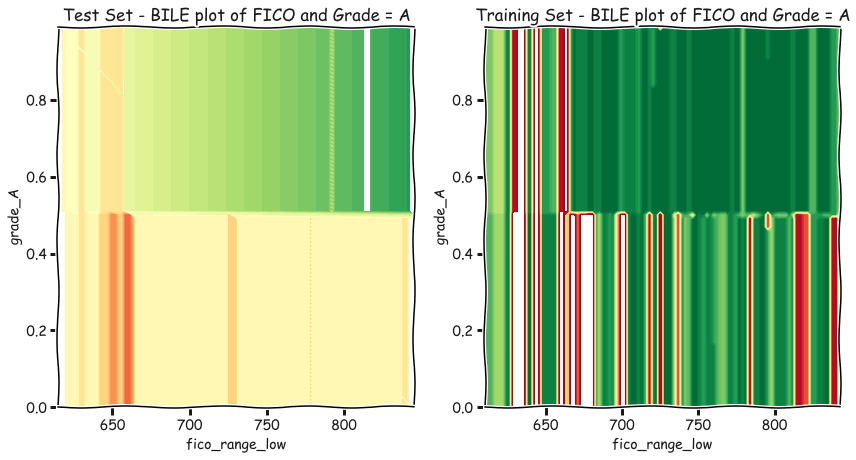

In [12]:
with plt.xkcd():
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,7))
    plot_decision_boundary_2d(x_test, model, 'fico_range_low', 'grade_A', \
                              'Test Set - BILE plot of FICO and Grade = A', ax=ax1);
    plot_decision_boundary_2d(x_train, model, 'fico_range_low', 'grade_A', \
                              'Training Set - BILE plot of FICO and Grade = A', ax=ax2);
    plt.show()

### Exercise 4: Make a BILE plot with interest rate and DTI ratio 
- HINT: Filter the dataframe to only plot rows with DTI below 70 (we want to see most of the data, not outliers)

In [27]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### LICE plots! 


- Have you noticed there are several features that always seem to come up in the most important in this model?
- Let's have a closer look at some of those featues using (Local) [ICE (Individual Conditional Expectation)](https://christophm.github.io/interpretable-ml-book/ice.html) plots.

LICE plots give us a picture of how a specific point behaves when one variable is moved univariately. Look at these plots and see what they tell you aboout the model's behavior. Does the behavior match your intutition?

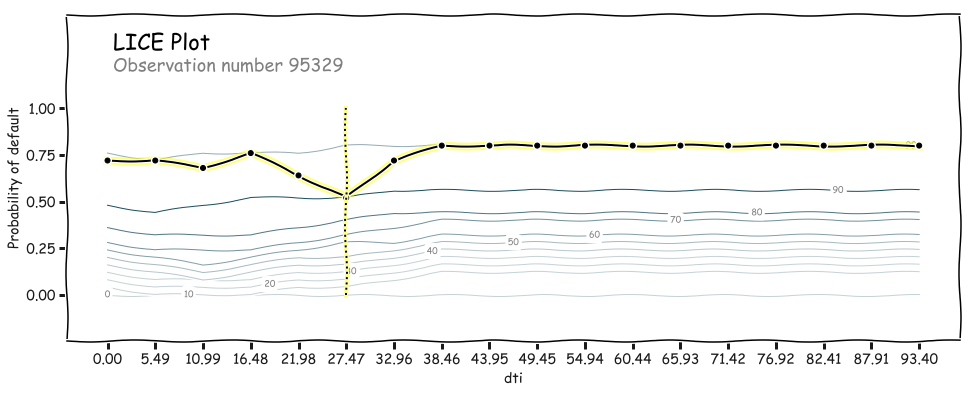

In [14]:
obs = 95329
lice_data = pd.concat([df_x.sample(10000, random_state=21), df_x.iloc[obs,:].to_frame().T], sort=False)

with plt.xkcd():
    interp.Lice.plot_lice(lice_data, model, 'dti', obs);

### Exercise 5: Make a LICE plot with the interest rate feature for point 95329
- HINT: You can use the `lice_data` variable from the previous plot to avoid resampling data

In [28]:
### ----------------------------------------------------------------------------------
### --------------------------- INSERT CODE BELOW ------------------------------------
### ----------------------------------------------------------------------------------



### Even more interpretability!

We will look at input gradients and Shapley values (although we only run Shapley values due to time) 

Input gradients use finite difference to find the derivative of the model w.r.t the input column while keeping all other features the same.  This measures the univariate impact of each feature for a specific observation.  We can get another mathematical viewpoint into the model's decision at a point and cross-reference with LIME.

#### Input gradients
- Relatively fast to run for single points
- Good mathematical basis
- Intuiative, but not a complete explaination 

#### Shapley values
 - [Shapley values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) are the gold standard in model interperatability.
 - They are based on a game theoretic approach to feature influence, and they are the only method with firm mathematical foundations.
 - Why don't we just always use them? They are *really* expensive computationally. 
 - [Here](https://towardsdatascience.com/one-feature-attribution-method-to-supposedly-rule-them-all-shapley-values-f3e04534983d) is a fantastic summary of Shapley values!

---------------------------------------------

### Shapley Values:

The visualization below explains which features influenced the model toward its final conclusion based on their marginal contribution to the model's output.

In [16]:
shap.initjs()
shap_data = pd.concat([df_x.sample(10, random_state=21), df_x.iloc[obs,:].to_frame().T], sort=False)
predict_fn = lambda x: model.predict_proba(x)[:,1]

# Create the KernelEstimator and sample
shap_exp = shap.KernelExplainer(predict_fn, shap_data)
shap_values = shap_exp.shap_values(shap_data)

# visualize the first prediction's explanation
display(shap.force_plot(shap_exp.expected_value, shap_values[-1,:], df_x.iloc[obs,:]))

100%|██████████| 11/11 [00:03<00:00,  3.51it/s]


<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Bonus Step: LIME in the wild

Real world problems often involve data outside of the nice tabular format like we used in this workshop.  Let's run through two quick examples with different data types.  

### Images

- Who doesn't love a deep learning example?!
- NOTE: This was taken from the [LIME official tutorials](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb) and the next cell will take 1 - 2 minutes to run depending on your hardware. 


('n02133161', 'American_black_bear', 0.63716)
('n02105056', 'groenendael', 0.031818103)
('n02104365', 'schipperke', 0.029944422)
('n01883070', 'wombat', 0.028509434)
('n01877812', 'wallaby', 0.0250936)


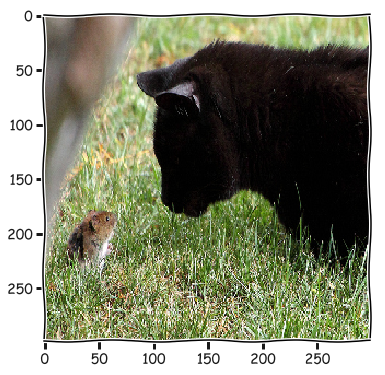

In [17]:
# Download InceptionV3 network 
inet_model = inc_net.InceptionV3()

# Image transforming function
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

images = transform_img_fn(['../data/cat_mouse.jpg'])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(8,6))
    ax.imshow(images[0] / 2 + 0.5)
    
# Get predictions 
preds = inet_model.predict(images)
for x in decode_predictions(preds)[0]:
    print(x)
    
# Fit LIME explainer (Takes about 1.5 mins to run)
iexplainer = lime_image.LimeImageExplainer()
explanation = iexplainer.explain_instance(images[0], inet_model.predict, top_labels=5, num_samples=1000)

### Resulting image explaination

In this explaination the green parts contribute to the chosen class, while the red parts contribute to a different class than the chosen one.

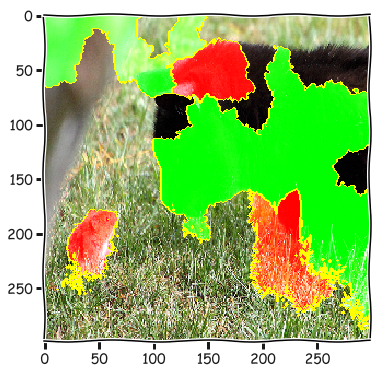

In [18]:
# Plot result 
temp, mask = explanation.get_image_and_mask(295, positive_only=False, num_features=10, hide_rest=False)
with plt.xkcd():
    fig,ax = plt.subplots(figsize=(8,6))
    ax.imshow(mark_boundaries(temp / 2 + 0.5, mask));

## Text Example: 

- We will cover the text example we touched on in the presentation (which is also in the [LIME tutorial](https://github.com/marcotcr/lime/blob/master/doc/notebooks/Lime%20-%20basic%20usage%2C%20two%20class%20case.ipynb) we used for this section)

This example shows a model that looks good initially. It has a high accuracy and F1 score, but when we look under the hood the model is picking up on the wrong signals.  It is looking at .edu domains and hosting information to determine is the content is atheist or Christian, instead of the actual content of the email. Interperatability is especially useful in finding models with undesirable behavior, like this one!  

In [19]:
# Load data
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']

# Transform data
vectorizer = TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)

# Train model
rf_text = RandomForestClassifier(n_estimators=500)
rf_text.fit(train_vectors, newsgroups_train.target)

pred = rf_text.predict(test_vectors)
print(f'Model F1 Score: {round(f1_score(newsgroups_test.target, pred, average="binary"),4)}')
print(f'Model Accuracy: {round(accuracy_score(newsgroups_test.target, pred),4)}')
print()

# Make pipeline and explainer 
c = make_pipeline(vectorizer, rf_text)
texplainer = LimeTextExplainer(class_names=class_names)

# Warning filter for older lime internals 
with warnings.catch_warnings():
    warnings.simplefilter("ignore", FutureWarning)
    
    # Get explaination
    idx = 83
    exp = texplainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=6)
    print('Document id: %d' % idx)
    print('Probability(christian) =', c.predict_proba([newsgroups_test.data[idx]])[0,1])
    print('True class: %s' % class_names[newsgroups_test.target[idx]])
    exp.show_in_notebook()

Model F1 Score: 0.9199
Model Accuracy: 0.9038

Document id: 83
Probability(christian) = 0.432
True class: atheism


<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Step 4: Fairness

### Census Income dataset

The previous dataset was thorough and complex enough to demonstrate interpretability techniques, but as it is an anonymized dataset, it has little to no information on sensitive features. We will switch to another dataset for this part that is more suited to analyzing fairness techniques, as it possesses information on gender and race. 

This dataset is called the **Census Income dataset**, and it associates features of working adults to **whether or not they make more than $50k/yr**. It is extracted from the 1994 Census database, and contains **48842 observations** with a mix of continuous and categorical features (14 in total).  

List of features:
- **age:** continuous. 
- **workclass:** categorical. 
- **education:** categorical. 
- **education-num:** continuous. 
- **marital-status:** categorical. 
- **relationship:** categorical. 
- **race:** categorical. 
- **sex:** categorical. 
- **capital-gain:** continuous. 
- **capital-loss:** continuous. 
- **hours-per-week:** continuous. 
- **fnlwgt:** (final weight) continuous. 
- **native-country:** categorical.

Response: binary, corresponding to >50K (1) or <=50K (0). 


#### Reference:
Ron Kohavi, "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid", Proceedings of the Second International Conference on Knowledge Discovery and Data Mining, 1996


### How do we import it?

To import this dataset in an easy way, we will use a very convenient module (that will be presented in detail later this afternoon!) called AIF360, created by IBM. It centralizes multiple fairness metrics and tools for training fair models, as well as easy ways to import useful datasets. We will be using it to import our dataset and ultimately create a fair model, but we will implement our own fairness metrics.

In [20]:
# Load Census Income Dataset from AIF360
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])
optim_options = {
    "distortion_fun": get_distortion_adult,
    "epsilon": 0.05,
    "clist": [0.99, 1.99, 2.99],
    "dlist": [.1, 0.05, 0]
}

 <span style="color:red">**Important:** you will get an error when you first try to import the dataset - It is completely normal. You will have to download some files and place them in a specific location that will be indicated in the error message. We will give some time for this.</span>

In [21]:
# Split into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.7], shuffle=True)

Let's now print some characteristics of our dataset to see what we just loaded.

In [22]:
print('Training Dataset shape:',dataset_orig_train.features.shape,'\n')
# print('Favorable and unfavorable labels:',dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
print('Protected attribute names:',dataset_orig_train.protected_attribute_names,'\n')
print('Privileged and unprivileged protected attribute values:' ,dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes,'\n')
print('Dataset feature names:',dataset_orig_train.feature_names,'\n')

Training Dataset shape: (34189, 18) 

Protected attribute names: ['sex'] 

Privileged and unprivileged protected attribute values: [array([1.])] [array([0.])] 

Dataset feature names: ['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12'] 



As we can see, we didn't import the exact dataset described above, we actually imported a slightly modified version with only binary features that are easier to understand and work with.

And we then extract numpy arrays from the dataset objects given by AIF360, standardizing the features in the process:

In [23]:
# Get numpy arrays for x_train, x_test, y_train, y_test by extracting data from AIF360 dataset object

# We define a scaler to normalize our data
scale_orig = StandardScaler()

# We get our training numpy arrays
x_train = scale_orig.fit_transform(dataset_orig_train.features) #This fit_transform from the scaler substracts mean and divides by std for each feature.
y_train = dataset_orig_train.labels.ravel()

# And our testing arrays
x_test = scale_orig.transform(dataset_orig_test.features) # Here, we only transform, as we can't use the testing set to define the scaling factors.
y_test = dataset_orig_test.labels.ravel()

### Training our classifier (Random Forest)

It is now time to train the classifier that we are going to Audit. We chose a RandomForest here for it's ease of manipulation, but any model with an sklearn interface can be used.

In [24]:
# Train classifier on original data
rf_model = RandomForestClassifier(n_estimators=25, 
                               max_depth=None,
                               random_state=42).fit(x_train, y_train)

rf_model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Getting initial accuracy

In [25]:
# Get predictions

preds_test = rf_model.predict(x_test)

acc_train = rf_model.score(x_train, y_train)
acc_test = rf_model.score(x_test, y_test)

print('Training accuracy of our classifier:',acc_train)
print('Testing accuracy of our classifier:',acc_test)

Training accuracy of our classifier: 0.8018368481090409
Testing accuracy of our classifier: 0.8084351327373234


The accuracy on test should be around 80%. As we will see later, this value will decrease when we try to make our model fair.

## Statistical Parity

We will first test our model's predictions with statistical parity, a simple fairness measure that is easy to compute.

### What is statistical parity?

This metric measures the difference between the probability of positive decisions for the protected group and the probability of positive decisions for the unprotected group. Mathematically:
$$Sp = P(d=1|G=0) - P(d=1|G=1)$$

This can be easily approximated with our data by calculating the proportion of positive decisions amongst people from gender "0" and substracting the proportion of positive decisions amongst people from gender "1":

$$Sp = \frac{ \text{# people with positive decision and gender 0}} { \text{ # people from gender 0} } - \frac{ \text{# people with positive decision and gender 1}} { \text{ # people from gender 1}}$$

Let's code a simple function that will calculate this for our dataset. In the next cell, complete the function `evaluate_statistical_parity` to perform the calculation above. The function definition and docstring will guide you.

In [26]:
# Statistical parity function
def evaluate_statistical_parity(predictions, protected_class_array):
    """Function to calculate statistical parity.

     Parameters
    ----------
    predictions (numpy array): binary decision labels outputted by our trained model.
    protected_class_array (numpy array): boolean mask where protected rows are marked True.

    Returns
    -------
    bias (float): statistical parity bias 
    (difference between proportion of positive decisions of protected class and unprotected class)
    """

    # --------------
    # --------------
    
    
    # Your code here
    
    prop_protected = # Complete here: sum of predictions AND protected_class_array, dividied by the sum of protected_class_array
    prop_not_protected = # Complete here: sun of preds AND NOT protected_class_array, divided by the sum of protected_class_array
    
    # --------------
    # --------------
    
    bias = np.abs(prop_protected - prop_not_protected)   
    return bias

SyntaxError: invalid syntax (<ipython-input-26-f9f53004bc69>, line 22)

### Testing statistical parity

We can now test this initial statistical measure and observe if our dataset is fair with respect to GENDER. 

In [ ]:
# Observing statistical parity on test set

GENDER_COLUMN = 1

predictions = rf_model.predict(x_test)>0.5
protected_class_array = dataset_orig_test.features[:,GENDER_COLUMN]==0 # Here, we're taking the column corresponding to 'sex' and we are transforming it into a boolean array

statistical_parity_orig = evaluate_statistical_parity(predictions, protected_class_array)

print('Statistical Parity on Test set:', statistical_parity_orig)

We should get a value around 0.2 . Statistical parity shows perfect fairness when the indicator is 0. In this case, we do have a certain amount of unfairness: the proportion of positive classifications is not the same on both groups. 

This is interesting, but we're observing the protected group as a whole. What happens if we zoom in on a part of the dataset fulfilling a certain condition? Are we more or less fair?

# Conditional Parity

Statistical parity is a simple measure, and it gives a fast overview on our model's fairness. However, it disregards important aspects of our dataset, such as the values of the features of each row. Consider the loan application again. We could have a situation where the statistical parity measure tells us that we are giving loans to 20% of people from gender 0 and 20% of people from gender 1, which would be fair, but those 20% from gender 0 are chosen at random, while the 20% from gender 1 are all from developed countries. Our model would be hiding another layer of unfairness: we are not giving loans equally to people from gender 1.

We can use conditional parity to detect these types of imbalances. Conditional parity allows us to test for unfairness in a similar way as Statistical Parity, but conditioning on another feature (for example, country of origin). The equation is:

$$Cp = P(d=1|G=0, C=c) - P(d=1|G=1, C=c)$$

Again, this can be easily calculated by counting the number of positive outcome cases in both protected groups, but this time only looking at the people that fulfill our conditional constraint (C=c). In simpler terms, the equation is:

$$Cp = \frac{ \text{# people with positive decision and gender 0 and condition c}} { \text{ # people from gender 0 and condition c} } - \frac{ \text{# people with positive decision and gender 1 and condition c}} { \text{ # people from gender 1 and condition c}}$$

We want to code this in the following function, `evaluate_conditional_parity`.

In [ ]:
# Conditional parity function
def evaluate_conditional_parity(predictions, protected_class_array, condition_array):
        """Function to calculate Conditional statistical parity.
        
         Parameters
        ----------
        predictions (numpy array): binary (decision) labels for X
        protected_class_array (numpy array): boolean array where protected rows are marked True
        condition_array (numpy array): boolean array that indicates conditional status
        
        Returns
        -------
        bias (float): conditional parity bias
        """
        
        # --------------
        # --------------
        
        
        # Your code here
        prop_protected = # Complete here (same as above, but now add the conditional array)
        prop_not_protected = # Complete here (same as above, but now add the conditional array)
        
        
        # --------------
        # --------------
        
        
        bias = np.abs(prop_protected - prop_not_protected)
        return bias

### Testing Conditional Parity
We want to see what happens when we look at the subgroup corresponding to race=1. Are we being fair, in terms of statistical parity, in that subgroup? Our conditional vector is very simple in this case: it just corresponds to the `race` column in our dataset. Remember, however, that we're still looking at fairness in terms of gender; we're just observing a racial subgroup.

In [ ]:
# Observing statistical parity on test set

GENDER_COLUMN = 1
AGE_40_COLUMN = 5

predictions = rf_model.predict(x_test)>0.5
protected_class_array = dataset_orig_test.features[:,GENDER_COLUMN]==0 
condition_array = dataset_orig_test.features[:,AGE_40_COLUMN]==1
conditional_parity_orig = evaluate_conditional_parity(predictions, protected_class_array, condition_array)

print('Conditional Parity on Test set, conditioned on people of race=1:', conditional_parity_orig)

We should get a conditional parity value of about 0.36. As we can see, we are actually being more unfair in the distribution of positive outcome for genders 0 and 1 in the subgroup corresponding to "age decade 40". This insight can be repeated with other subgroups of interest to assess the fairness of our algorithm in different cases.

Up until now, we haven't looked at the validity of our predictions. What happens if we're interested in balancing the amount of *errors* that we make?

The next metric will help us on that front.

# False Positive (Negative) Error Rate Balance

The previous measures don't take into account the real labels of each observation; they only consider the predictions. The measure of fairness proposed here controls for equal poportions of false positives/false negatives in protected and unprotected classes. This measure is ideal in cases where committing mistakes disproportionately for different protected groups can bring negative outcomes.

We will again code these measures as they are rather easy to understand. The function definition below will guide you through the process.

In [ ]:
# False positive and false negative rates
def evaluate_false_negative_rate(predictions, protected, y):
    """evaluate fnr

    Parameters
    ----------
    predictions (numpy array): binary (decision) labels for X predicted by our model
    protected (numpy array): boolean mask where protected rows are marked True or 1
    y (numpy array): boolean array that marks ground truth

    Note:
        FNR: FN / CP where FN=(predictions==0) & (y==1) CN = (y==1)

    Returns
    -------
    bias (float)
    """

    
    
    cond_pos_protected = np.sum((y==1) & protected)
    cond_pos_not_protected = np.sum((y==1) & ~protected)
    
    if cond_pos_protected == 0:
        return 'No Condition Positive in Protected'
    if cond_pos_not_protected == 0:
        return 'No Condition Positive in Not Protected'

    # --------------
    # --------------
    
    # Your code here
    
    false_neg_protected = # Complete here: sum of (ground truth ==1 AND predictions ==0 AND protected)
    false_neg_not_protected = # Complete here: sum of (ground truth ==1 AND predictions ==0 AND NOT protected)
    
    # --------------
    # --------------
    

    fnr_g = false_neg_protected / cond_pos_protected
    fnr_not_g = false_neg_not_protected / cond_pos_not_protected
    bias = np.abs(fnr_g - fnr_not_g)
    
    return bias


def evaluate_false_positive_rate(predictions, protected, y):
    """evaluate fpr

    Parameters
    ----------
    predictions (numpy array): binary (decision) labels for X predicted by our model
    protected (numpy array): boolean mask where protected rows are marked True or 1
    y (numpy array): boolean array that marks ground truth

    Note:
        FPR: FP / CN where FP=(predictions==1) & (y==0) CN = (y==0)

    Returns
    -------
    bias (float)
    """

    cond_neg_protected = np.sum((y==0) & protected)
    cond_neg_not_protected = np.sum((y==0) & ~protected)
    
    if cond_neg_protected == 0:
        return 'No Condition Negative in Protected'
    if cond_neg_not_protected == 0:
        return 'No Condition Negative in Not Protected'

    
    # --------------
    # --------------
    
    
    # Your code here
    
    
    false_pos_protected = # Complete Here. Same as above, but with predictions==1
    false_pos_not_protected = # Complete Here. Same as above, but with predictions==1
    
    # --------------
    # --------------
    

    fpr_g = false_pos_protected / cond_neg_protected
    fpr_not_g = false_pos_not_protected / cond_neg_not_protected
    bias = np.abs(fpr_g - fpr_not_g)
    return bias


### Testing FPR and FNR

Again, we want these measures to be as close to zero as possible.

In [ ]:
# Test FPR and FNR
fpr = evaluate_false_positive_rate(predictions, protected_class_array, y_test)
fnr = evaluate_false_negative_rate(predictions, protected_class_array, y_test)

print('False positive rate: ',fpr)
print('False negative rate:',fnr)

As we can see, the values of FPR and FNR are not as close to zero as we would want, showing at least a 10% disparity between the errors on protected classes vs the rest of the population.

## Other Fairness metrics 

We have coded and tested some basic Fairness metrics, but there are multiple other metrics that can be used, depending on the situation. Some of them are:

**Predictive parity:**
The fraction of correct positive predictions should be the same for protected and unprotected groups.
$$P(Y=1|d=1, G=m) = P(Y=1|d=1, G=f)$$


**Equalized odds:**
Applicants with a good actual credit scope and applicants with a bad actual credit
score should have a similar classification, regardless of the value of the protected class.
$$P(d=1|Y=i, G=m) = P(d=1|Y=i, G=f), i\in \{0,1\}$$


**Overall accuracy equality:**
Both protected and unprotected groups have equal prediction accuracy.
$$P(d=Y, G=m) = P(d=Y, G=f)$$


**Treatment Equality:**
Looks at ratio of errors a classifier makes instead of its accuracy. Satisfied if both protected and unprotected groups have equal ratio of false negatives and false positives.


We will not go through all of them in code to save time. We will now try to generate a fair model.

# Creating a Fair Model

Once we have characterized and measured the fairness of the model, we might want to build a model that avoids discrimination given a protected class. As there are multiple ways to define fairness, there are also multiple ways to build a fair classifier, depending on what notion we want to emphasize.

Some options are:
- Preprocessing the data to remove biases, and training normal classifiers on that data
- Training the classifier and post-processing the predictions to accomodate our measures of fairness
- Training a modified classifier with clear constraints that enforce fairness

We will exemplify the Optimized Preprocessing technique, published by our very own Flavio Calmon. We will use AIF360 for this, which already has everything we need to work out of the box. This technique, as expected, corresponds to the realm of data preprocessing.

Workflow of optimized preprocessing:

![Optimized Preprocessing Workflow](OptimPreprocessingGraph.PNG)

### Recap

Let's take a look at the values we have so far.

In [ ]:
# Getting accuracy and fairness metrics on test

print('Training accuracy of our classifier:',acc_train)
print('Testing accuracy of our classifier:',acc_test)
print('Statistical Parity on Test set:', statistical_parity_orig)
print('Conditional Parity on Test set, conditioned on people of race=1:', conditional_parity_orig)
print('False positive rate on Test set: ',fpr)
print('False negative rate on Test set:',fnr)

### Let's apply a dataset transformation to increase fairness !

Using AIF360 OptimPreproc module, we can transform our dataset into a new representation that will improve our metrics above.

In [ ]:
# Instantiate OptimizedDataPreprocessing module from AIF360    
OP = OptimPreproc(OptTools, optim_options,
                  unprivileged_groups = unprivileged_groups,
                  privileged_groups = privileged_groups)

# Fit the module to the training data, effectively creating the mapping from original data to transformed, fair data
OP = OP.fit(dataset_orig_train)

In [ ]:
# Transform training data and align features
dataset_transf_train = OP.transform(dataset_orig_train, transform_Y=True)
dataset_transf_train = dataset_orig_train.align_datasets(dataset_transf_train)

# Same with test data
dataset_transf_test = OP.transform(dataset_orig_test, transform_Y = True)
dataset_transf_test = dataset_orig_test.align_datasets(dataset_transf_test)

In [ ]:
# Again, we have to get our training numpy arrays, this time on the TRANSFORMED training data
x_train_transf = scale_orig.fit_transform(dataset_transf_train.features)
y_train_transf = dataset_transf_train.labels.ravel()

# And our testing arrays, on the TRANSFORMED test data
x_test_transf = scale_orig.transform(dataset_transf_test.features) # Here, we only transform, as we can't use the testing set to define the scaling factors.
y_test_transf = dataset_transf_test.labels.ravel()

In [ ]:
# Train classifier on TRANSFORMED data
rf_model_transf = RandomForestClassifier(n_estimators=25, 
                               max_depth=None,
                               random_state=42).fit(x_train_transf, y_train_transf)
rf_model_transf.fit(x_train_transf, y_train_transf)

In [ ]:
# Getting accuracy and fairness metrics on TRANSFORMED test set
acc_transf_train = rf_model_transf.score(x_train_transf, y_train_transf)
acc_transf_test = rf_model_transf.score(x_test_transf, y_test_transf)
print('Accuracy on test with original data (we should expect a bit less than before):', acc_transf_test)


In [ ]:
# Getting NEW fairness metrics

predictions_transf = rf_model_transf.predict(x_test_transf)>0.5
protected_class_array_transf = dataset_orig_test.features[:,GENDER_COLUMN]==0 

statistical_parity_transf = evaluate_statistical_parity(predictions_transf, protected_class_array_transf)
conditional_parity_transf = evaluate_conditional_parity(predictions_transf, protected_class_array_transf, condition_array)
fpr_transf = evaluate_false_positive_rate(predictions_transf, protected_class_array_transf, y_test_transf)
fnr_transf = evaluate_false_negative_rate(predictions_transf, protected_class_array_transf, y_test_transf)

In [ ]:
# COmparing metrics
print('ORIGINAL DATA')
print('Training accuracy of our classifier:',acc_train)
print('Testing accuracy of our classifier:',acc_test)
print('Statistical Parity on Test set:', statistical_parity_orig)
print('Conditional Parity on Test set, conditioned on people of race=1:', conditional_parity_orig)
print('False positive rate on Test set: ',fpr)
print('False negative rate on Test set:',fnr)


print('\n\nTRANSFORMED DATA')
print('Training accuracy of our classifier:',acc_transf_train)
print('Testing accuracy of our classifier:',acc_transf_test)
print('Statistical Parity on Test set:', statistical_parity_transf)
print('Conditional Parity on Test set, conditioned on people of race=1:', conditional_parity_transf)
print('False positive rate on Test set: ',fpr_transf)
print('False negative rate on Test set:',fnr_transf)

As we can see, our Fairness metrics improved in all cases, and our accuracy took a hit, as expected.

# Conclusion

We have analyzed particular fairness metrics and observed their behavior on an artificial dataset. It is important to remember that Fairness has multiple definitions, each one approriate for analyzing a specific situation. Statistical notions of fairness as described above are easy to measure. However, it is important to keep in mind that statistical definitions are insufficient in some cases (for example, when similarity has to be taken into account). Moreover, most valuable statistical metrics assume availability of actual, verified outcomes. While such outcomes are available for the training data, it is unclear whether the real classified data always conforms to the same distribution.

# Appendix: extra resources

## Interesting Fairness analysis tools
- Pymetrics audit-ai (https://github.com/pymetrics/audit-ai)
- fairness metrics github (https://github.com/megantosh/fairness_measures_code)
- fairness-comparison github (https://github.com/algofairness/fairness-comparison)
- IBM AIF360 (https://github.com/IBM/AIF360, https://arxiv.org/pdf/1810.01943.pdf)
- Themis ML (https://themis-ml.readthedocs.io/en/latest/)
- FairML (https://github.com/adebayoj/fairml)
- BlackBoxAuditing (https://github.com/algofairness/BlackBoxAuditing)

## Interesting papers
- Learning Fair Representations (seminal paper) http://proceedings.mlr.press/v28/zemel13.pdf
- Optimized Data Pre-Processing for Discrimination Prevention (by Flavio Calmon) https://arxiv.org/pdf/1704.03354.pdf
- Fairness Definitions Explained http://fairware.cs.umass.edu/papers/Verma.pdf
- From parity to Preference-based notions of fairness https://arxiv.org/abs/1707.00010
- Certifying and removing disparate impact https://arxiv.org/pdf/1412.3756.pdf
- Learning Classification without Disparate Mistreatment https://arxiv.org/pdf/1610.08452.pdf
- Fairness Constraints: Mechanisms for Fair Classification https://arxiv.org/abs/1507.05259
- Fairness GAN https://arxiv.org/pdf/1805.09910.pdf
- Adversarial Debiasing https://arxiv.org/pdf/1801.07593.pdf
- Classification with Fairness Constraints: A Meta-Algorithm with Provable Guarantees https://arxiv.org/pdf/1806.06055.pdf


## Fairness concepts
- **Fairness through unawareness:**
No sensitive attributes used in the decision making process.
- **Fairness through awareness:**
Similar individuals should have similar classification.
- **Disparate impact:**
Exists when decision outcomes disproportionately benefits or hurts individuals of a certain group.
- **Disparate treatment:**
Decision changes when protected feature changes.
- **Disparate mistreatment:**
Missclassification rates are different for people of different protected groups


We refer the reader to http://fairware.cs.umass.edu/papers/Verma.pdf for more information.